In [1]:
import torch
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapter
from ip_adapter.utils import generate

In [2]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder/"
ip_ckpt = "models/ip-adapter_sd15.bin"
device = "cuda"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [4]:
# load t2i-adapter
adapter_model_path = "diffusers/t2iadapter_depth_sd15v2/"
adapter = T2IAdapter.from_pretrained(adapter_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionAdapterPipeline.from_pretrained(
    base_model_path,
    adapter=adapter,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.t2i_adapter.pipeline_stable_diffusion_adapter.StableDiffusionAdapterPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


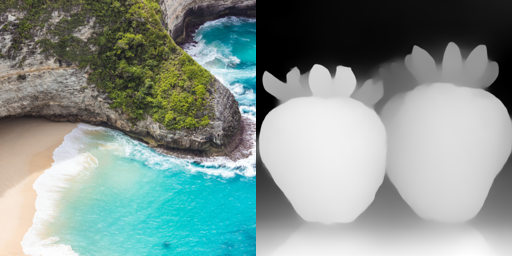

In [5]:
# read image prompt
image = Image.open("assets/images/river.png")
depth_map = Image.open("assets/structure_controls/depth2.png")
image_grid([image.resize((256, 256)), depth_map.resize((256, 256))], 1, 2)

In [6]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/pipelines/t2i_adapter/pipeline_stable_diffusion_adapter.py:426: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


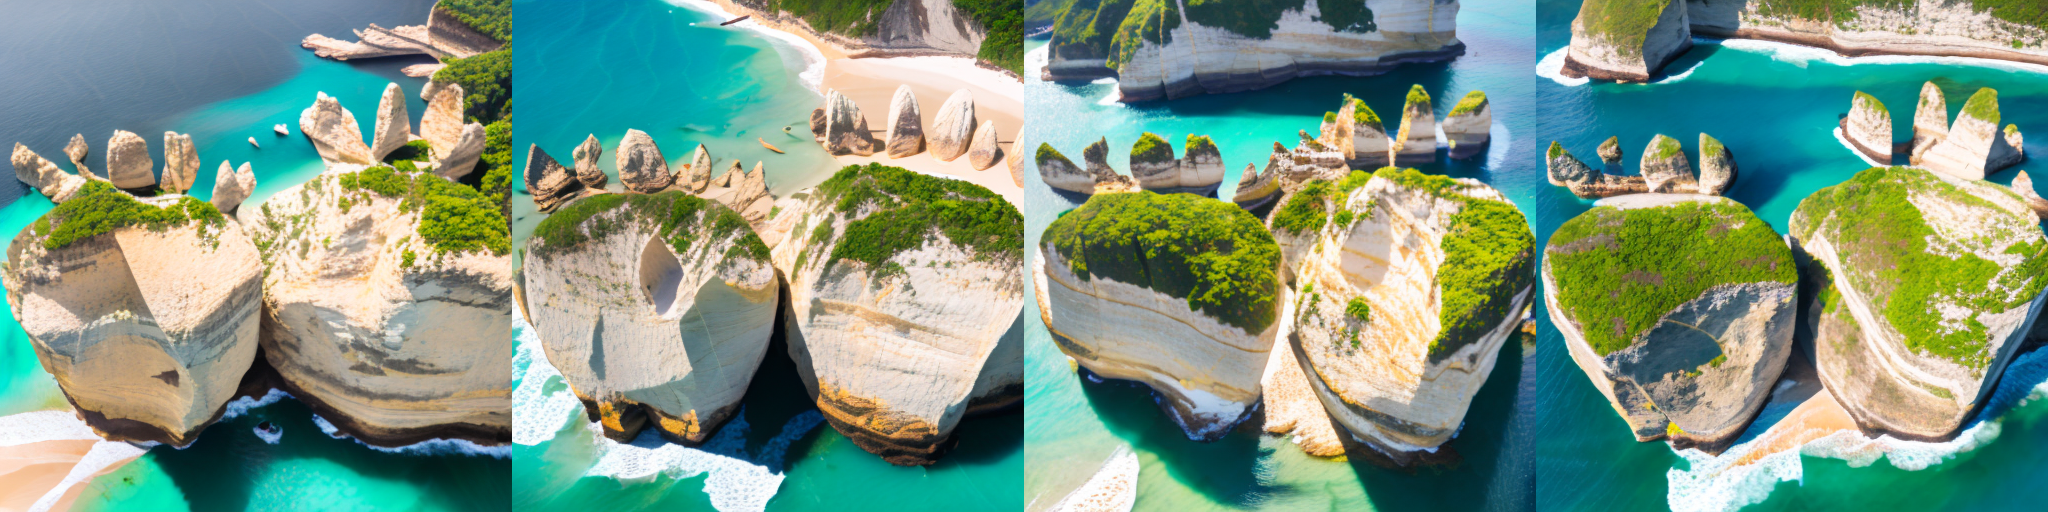

In [7]:
# generate image
num_samples = 4
depth_map = [depth_map] * num_samples # a bug of diffuser, we have to set the number by hard code
images = ip_model.generate(pil_image=image, image=depth_map, num_samples=num_samples, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, num_samples)
grid